In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    HumanMessage,
    ToolMessage,
    
)
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId
from pydantic import BaseModel, Field

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import RetryOutputParser
from typing_extensions import TypedDict
from typing import Annotated,Optional,List

#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import os
from dotenv import load_dotenv 




import datetime
import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

load_dotenv()
GOOGLE_API_KEY=os.getenv('google_api_key')

In [2]:
GEMINI_MODEL='gemini-2.0-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [3]:
class State(TypedDict):
    node_message: str
    calendar: dict
    route: str
    query: str

In [4]:
def router(state:State):
    route = state.get('route')
    
    routing_map = {
        'show_calendar': 'to_show_calendar',
        'create_event': 'to_create_event',
        'quick_add_event': 'to_quick_add_event'
    }
    
    return routing_map.get(route)

In [5]:




if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json")


try:
    service = build("calendar", "v3", credentials=creds)

    # # Call the Calendar API
    # now = datetime.datetime.now().isoformat() + "Z"  # 'Z' indicates UTC time
    # print("Getting the upcoming 10 events")
    # events_result = (
    #     service.events()
    #     .list(
    #         calendarId="primary",
    #         timeMin=now,
    #         maxResults=10,
    #         singleEvents=True,
    #         orderBy="startTime",
    #     )
    #     .execute()
    # )
    # events = events_result.get("items", [])

    # if not events:
    #     print("No upcoming events found.")
      
    # # Prints the start and name of the next 10 events
    # for event in events:
    #     start = event["start"].get("dateTime", event["start"].get("date"))
    #     print(start, event["summary"])

except HttpError as error:
    print(f"An error occurred: {error}")


In [6]:
def agent_node(state:State):
    class Route(BaseModel):
        route: str = Field(description="the route for the next node, either, show_calendar, create_event, quick_add_event")
           
            


    parser=JsonOutputParser(pydantic_object=Route)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
      )

      
    chain = prompt | llm 
    
    response=chain.invoke({'query':f'choose the route based on this query: {state.get('query')}'}) 
    try:
        response=parser.parse(response.content)
        return {'route':response.get('route')}
    except:
        
        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

        prompt_value = prompt.format_prompt(query=state['query'])
        response=retry_parser.parse_with_prompt(response.content, prompt_value)
        return {'route':response.get('route')} 

In [7]:
# Call the Calendar API
def get_events_node(state: State):
    now = datetime.datetime.now().isoformat() + "Z"  # 'Z' indicates UTC time

    events_result = (
        service.events()
        .list(
            calendarId="primary",
            timeMin=now,
            maxResults=20,
            singleEvents=True,
            orderBy="startTime",
        )
        .execute()
    )
    events = events_result.get("items", [])
    ev={}
    for e in events:
        try:
            id= e.get('id')
            summary=e.get('summary')
            creator=e.get('creator')
            start=e.get("start").get("dateTime", e.get("start").get("date"))
            end=e.get("end").get("dateTime", e.get("end").get("date"))
            ev[start]={'summary':summary,
                    'creator':creator,
                    'start':start,
                    'end':end,
                        'event_id':id}
        except: ev[start]=e

    return {'calendar':ev}
    

    

In [8]:
def show_calendar_node(state:State):
    return {'node_message':state.get('calendar')}

In [9]:
def create_event_node(state: State):
    
  class Event(BaseModel):
      summary: str = Field(description='the title of the event')
      location: str = Field(description='the address or location of the event')
      description: str = Field(description='the description of the event')
      start_time: str = Field(description='the start time of an event, has to be formatted as such: eg. 2015-05-28T09:00:00-07:00')
      end_time: str = Field(description='the end time of an event, has to be formatted as such: eg. 2015-05-28T09:00:00-07:00')
      recurrence: str = Field(description='to define the recurrence of the event(DAILY, WEEKLY, MONTHLY, YEARLY), follow this format eg. RRULE:FREQ=DAILY;COUNT=2, if not mentionned put an empty string')
  
  parser=JsonOutputParser(pydantic_object=Event)
  prompt = PromptTemplate(
  template="Answer the user query.\n{format_instructions}\n{query}\n",
  input_variables=["query"],
  partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    
  chain = prompt | llm 
  
  response=chain.invoke({'query':f'create an event based on this query: {state.get('query')}'}) 
  try:
      response=parser.parse(response.content)
     
  except:
      
      retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

      prompt_value = prompt.format_prompt(query=state['query'])
      response=retry_parser.parse_with_prompt(response.content, prompt_value)
      
  event = {
  'summary': response.get('summary'),
  'location': response.get('location'),
  'description': response.get('description'),
  'start': {
    'dateTime': response.get('start_time'),
    'timeZone': response.get('timezone'),
  },
  'end': {
    'dateTime': response.get('end_time'),
    'timeZone': 'America/New_york',
  },
  'recurrence': [
    response.get('recurrence')
  ],
  'reminders': {
    'useDefault': False,
    'overrides': [
      {'method': 'email', 'minutes': 24 * 60},
      {'method': 'popup', 'minutes': 10},
    ],
  },
}
  try:
    event = service.events().insert(calendarId='primary', body=event).execute()
    return {'node_massage':'Event Created'}
  except: 
    return {'node_message':'Failed to create event'}
  

In [10]:

def quick_add_event_node(state:State):
    
    class Event(BaseModel):
        event_description: str = Field(description="a description of the event, including the start and end time (eg. 'Appointment at Somewhere on June 3rd 10am-10:25am' )")
           
            


    parser=JsonOutputParser(pydantic_object=Event)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
      )

      
    chain = prompt | llm 
    
    response=chain.invoke({'query':f'create an event based on this query: {state.get('query')}'}) 
    try:
        response=parser.parse(response.content)
        
    except:
        
        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

        prompt_value = prompt.format_prompt(query=state['query'])
        response=retry_parser.parse_with_prompt(response.content, prompt_value)
      
    try:
        created_event = service.events().quickAdd(
        calendarId='primary',
        text=response.get('event_description')).execute()
        return {'node_massage':'Event Created'}
    except: 
        return {'node_message':'Failed to create event'}

In [11]:
class Calendar_agent:
    def __init__(self):
        self.agent=self._setup()
    def _setup(self):
   
     



        graph_builder = StateGraph(State)

        # Modification: tell the LLM which tools it can call

        graph_builder.add_node("agent", agent_node)

        graph_builder.add_node('get_events',get_events_node)
        graph_builder.add_node("show_calendar", show_calendar_node)
        graph_builder.add_node('create_event', create_event_node)
        graph_builder.add_node('quick_add_event', quick_add_event_node)
        # Any time a tool is called, we return to the chatbot to decide the next step
        graph_builder.add_edge(START,'get_events')
        graph_builder.add_edge("get_events", "agent")
        graph_builder.add_conditional_edges(
            "agent",
            router,{
                'to_show_calendar': 'show_calendar',
                'to_create_event': 'create_event',
                'to_quick_add_event': 'quick_add_event'
            }
        )
        graph_builder.add_edge("show_calendar", END)
        graph_builder.add_edge('create_event', END)
        graph_builder.add_edge('quick_add_event',END)
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory)
        return graph
        

    def display_graph(self):
        return display(
                        Image(
                                self.agent.get_graph().draw_mermaid_png(
                                    draw_method=MermaidDrawMethod.API,
                                )
                            )
                        )
    def chat(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'query':input
                                    },config)
        return response

    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        for event in self.agent.stream({'query':input
                                        }, config, stream_mode="updates"):
            print(event)
    
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]

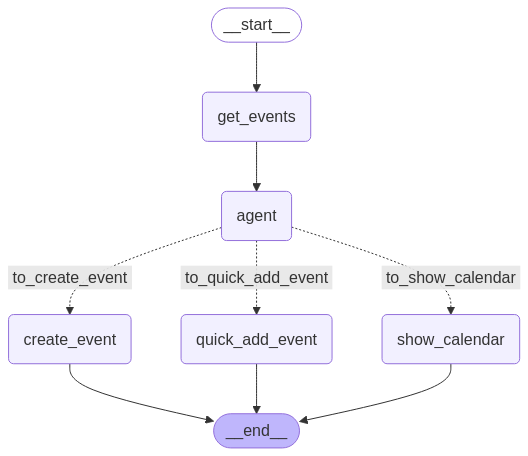

In [12]:
agent=Calendar_agent()
agent.display_graph()

In [15]:
agent.chat('show calendar')

{'node_message': {'2025-06-02': {'summary': "pascale padiou's birthday",
   'creator': {'email': 'padioutristan@gmail.com', 'self': True},
   'start': '2025-06-02',
   'end': '2025-06-03',
   'event_id': 'o2q1d9usksahodftv3872lits0_20250602'},
  '2025-09-07T11:00:00-04:00': {'summary': 'Titouan: Festival, ile de re',
   'creator': {'email': 'padioutristan@gmail.com', 'self': True},
   'start': '2025-09-07T11:00:00-04:00',
   'end': '2025-09-07T12:00:00-04:00',
   'event_id': '3gj9pktuojrdda1rks7uf4b3sh'},
  '2025-12-14': {'summary': 'Loanne birthday',
   'creator': {'email': 'padioutristan@gmail.com', 'self': True},
   'start': '2025-12-14',
   'end': '2025-12-15',
   'event_id': '3fvhjh0t8sh2ffpa3otg772q3k_20251214'},
  '2025-12-21': {'summary': 'Anna birthday',
   'creator': {'email': 'padioutristan@gmail.com', 'self': True},
   'start': '2025-12-21',
   'end': '2025-12-22',
   'event_id': '07grgqniiemg5fkqrqv5a168jg_20251221'},
  '2026-06-02': {'summary': "pascale padiou's birthday"

In [14]:
agent.get_state('node_message')

{'2025-06-02': {'summary': "pascale padiou's birthday",
  'creator': {'email': 'padioutristan@gmail.com', 'self': True},
  'start': '2025-06-02',
  'end': '2025-06-03',
  'event_id': 'o2q1d9usksahodftv3872lits0_20250602'},
 '2025-09-07T11:00:00-04:00': {'summary': 'Titouan: Festival, ile de re',
  'creator': {'email': 'padioutristan@gmail.com', 'self': True},
  'start': '2025-09-07T11:00:00-04:00',
  'end': '2025-09-07T12:00:00-04:00',
  'event_id': '3gj9pktuojrdda1rks7uf4b3sh'},
 '2025-12-14': {'summary': 'Loanne birthday',
  'creator': {'email': 'padioutristan@gmail.com', 'self': True},
  'start': '2025-12-14',
  'end': '2025-12-15',
  'event_id': '3fvhjh0t8sh2ffpa3otg772q3k_20251214'},
 '2025-12-21': {'summary': 'Anna birthday',
  'creator': {'email': 'padioutristan@gmail.com', 'self': True},
  'start': '2025-12-21',
  'end': '2025-12-22',
  'event_id': '07grgqniiemg5fkqrqv5a168jg_20251221'},
 '2026-06-02': {'summary': "pascale padiou's birthday",
  'creator': {'email': 'padioutrist